<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment3/Session3_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **SESSION 3 ASSIGNMENT**

**Problem Statement**:
* take 2 inputs:
  * an image from MNIST dataset, and
  * a random number between 0 and 9
* give two outputs:
  * the "number" that was represented by the MNIST image, and
  * the "sum" of this number with the random number that was generated and sent as the input to the network

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#### **Get Train and Test Data**
* **DataSet Used** Customized MNIST data

##### **Download MNIST Train and Test Data**

In [ ]:
# Get Train Data
train_data = torchvision.datasets.MNIST(
    root='./data',
    train= True,
    download= True,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)

# Get Test Data
test_data = torchvision.datasets.MNIST(
    root='./data',
    train= False,
    download= True,
    transform = transforms.Compose(
        [transforms.ToTensor()]
    )
)

In [ ]:
len(train_data)

60000

In [ ]:
len(test_data)

10000

##### **Generate Custom Mnist Data**
* **Custom Data** should have random number and sum label as well
* DataSet Has following information:
  * **MNIST Image Information**
  * **One Hot Encoded Random Number**
    * random number is generated from 0 to 9
    * converted to one hot encoding vector
  * **MNIST Image Label**
  * **SUM Label**
    * sum of mnist label plus random number

In [ ]:
# Generate Custom Dataset
class CustomDataSet(Dataset):
  def __init__(self, mnist_train_data):
    """
      For Loop Explanation:
        1. itearte through each row in dataset
        2. Generate a random number
        3. Add random plus mnist_label
        4. Append mnist_image_data, mnist_label, random_number and sum to data list
    """
    self.data = []
    for mnist_image, mnist_label in iter(mnist_train_data):
      random_number = np.random.randint(0, 9) # Generating a random number between 0 to 9
      sum_label = mnist_label + random_number
      # Generate one hot encoding vector using torch nn.functional package
      # https://pytorch.org/docs/master/generated/torch.nn.functional.one_hot.html
      encoded_random_number = F.one_hot(torch.tensor(random_number), num_classes=10)
      # Append All information into data
      self.data.append(
          (
              mnist_image,
              encoded_random_number,
              mnist_label,
              sum_label
           )
      )

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    mnist_image, random_number, mnist_label, sum_label = self.data[index]
    return mnist_image,random_number, mnist_label, sum_label

In [ ]:
# Customized Mnist Train and Test Data
final_train_data = CustomDataSet(train_data)
final_test_data = CustomDataSet(test_data)

In [ ]:
len(next(iter(final_train_data))) 

4

In [ ]:
# shape of encoded random. number data
next(iter(final_train_data))[1].shape

torch.Size([10])

In [ ]:
sample = next(iter(final_train_data)) # 1 sample
mnist_image, random_number, mnist_label, sum_label = sample

== LABEL ==:  5
== Random Number ==:  tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
== Sum ==:  7


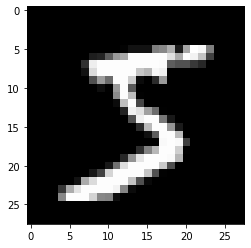

In [ ]:
plt.imshow(mnist_image.squeeze(), cmap='gray')
print("== LABEL ==: ", mnist_label)
print("== Random Number ==: ", random_number)
print("== Sum ==: ", sum_label)

#### **Load Data**

In [ ]:
# Load Data using DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset= final_train_data,
    batch_size= 128,
    shuffle= True
)

test_loader = torch.utils.data.DataLoader(
    dataset= final_test_data,
    batch_size= 128,
    shuffle= True
)

In [ ]:
len(next(iter(train_loader)))

4

In [ ]:
sample = next(iter(train_loader))
mnist_image, random_number, mnist_label, sum_label = sample

print("== Image Shape ==: ", mnist_image.shape)
print("== Random Number Shape ==: ", random_number.shape)
print("== Mnist Label Shape ==: ", mnist_label.shape)
print("== Sum Shape ==: ", sum_label.shape)

== Image Shape ==:  torch.Size([128, 1, 28, 28])
== Random Number Shape ==:  torch.Size([128, 10])
== Mnist Label Shape ==:  torch.Size([128])
== Sum Shape ==:  torch.Size([128])


#### **Network Design**
* Network:
  * 7 conv layers
  * 2 max pool layers
  * 2 fully connected layers

* Reason for 7 conv layers 
  * kernel size 3
  * increased output channels in multiple of 2
  * 7th conv layers will give 10 outputs so that concatenation with encoded random tensor will of same dimemsion
  * Adjusted padding so that 7th conv layer be give 10 outputs

* Concatination of the two inputs:
  * The output of the 7th conv layer contains the 10 tensor values of the MNIST image input and concatinated with the the one hot encoded random number tensor to pass  through a fully connected layer.
  * The fully connected layer increases the parameter and then shrunks back to a final output tensor of 19 passing through a log_softmax().

In [ ]:
# Network Design
class Network(nn.Module):
  def __init__(self):
    super().__init__() 
    # 1x28x28
    self.conv1 = nn.Conv2d(
        in_channels= 1,
        out_channels= 32,
        kernel_size= 3,
        padding=1
    ) # 32x28x28

    self.conv2 = nn.Conv2d(
        in_channels=32, 
        out_channels=64, 
        kernel_size=3,
        padding=1
    )  # 64x28x28

    self.max_pool1 = nn.MaxPool2d(2, 2) # 64x14x14
                     
    self.conv3 = nn.Conv2d(
        in_channels= 64, 
        out_channels= 128, 
        kernel_size= 3,
        padding=1
    )  # 128x14x14

    self.conv4 = nn.Conv2d(
        in_channels= 128, 
        out_channels= 256, 
        kernel_size= 3,
        padding=1
    )    # 256x14x14

    self.max_pool2 = nn.MaxPool2d(2, 2)  # 256x7x7
    
    self.conv5 = nn.Conv2d(
        in_channels= 256, 
        out_channels= 512, 
        kernel_size= 3
    )  # 512x5x5

    self.conv6 = nn.Conv2d(
        in_channels= 512, 
        out_channels= 1024, 
        kernel_size= 3
    )  # 1024x3x3

    self.conv7 = nn.Conv2d(
        in_channels= 1024, 
        out_channels= 10,
        kernel_size= 3
    )  # 10x1x1

    # out received from above layer is 10x1x1
    # send one hot encoded random vector
    # so total input features will become 20
    self.fc1 = nn.Linear(
        in_features= 20,
        out_features= 64
    )    

    self.fc2 = nn.Linear(
        in_features= 64,
        out_features= 19
    )


  def forward(self, mnist_image, random_number):
    mnist_image = self.conv1(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv2(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.max_pool1(mnist_image)

    mnist_image = self.conv3(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv4(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.max_pool2(mnist_image)

    mnist_image = self.conv5(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv6(mnist_image)
    mnist_image = F.relu(mnist_image)
    mnist_image = self.conv7(mnist_image)

    mnist_image = mnist_image.reshape(-1, 10) # 1x10

    # Concatenate encoded random number vector with reshaped mnist_image
    # 1x20
    random_number = torch.cat(
        (
            mnist_image,
            random_number
        ),
        dim= 1
    ) # 1x20

    # Pass concat vector to fully connected layers
    random_number = self.fc1(random_number)
    random_number = F.relu(random_number)
    random_number = self.fc2(random_number)

    return F.log_softmax(mnist_image), F.log_softmax(random_number)

In [ ]:
# Use cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
network = Network()
network.to(device)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=19, bias=True)
)

In [ ]:
batch = next(iter(train_loader))
len(batch)

4

In [ ]:
mnist_images, random_numbers, mnist_labels, sum_labels = batch

print(mnist_images.shape, random_numbers.shape)

pred_1, pred_2 = network(mnist_images.to(device), random_numbers.to(device))

print(pred_1.shape, pred_2.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128, 10])
torch.Size([128, 10]) torch.Size([128, 19])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.set_grad_enabled(True) # enable gradients

In [ ]:
# default configuration parameters do well on most problems
# default learning rate used i.e 0.001
optimizer = torch.optim.Adam(network.parameters())

In [ ]:
# function to return accuracy
def get_num_correct(preds, labels):
  preds = torch.argmax(preds,dim=1)

  total_count = 0
  for i in range(len(preds)):
    if preds[i] == labels[i]:
      total_count += 1
  return total_count/len(preds)

#### **TRAINING**

Loss Calculation: 
If mnist accuracy falls below 95 then mnist loss will be used
* Other sum loss is used
*  Experimented with couple of scenarios
   1. using mnist_loss
   2. using using sum_loss
   3. mnist_loss + sum_loss
* Using loss in the following gave better results comapred to above 3 scenarios



In [ ]:
# Training Loop
for epoch in range(2):

    mnist_loss = 0
    sum_loss = 0
    mnist_accuracy = 0
    sum_accuracy = 0

    for idx, batch in enumerate(train_loader): # Get Batch
        mnist_images, random_numbers, mnist_labels, sum_label = batch 

        mnist_labels_predicted, sum_predicted = network(
            mnist_images.to(device), 
            random_numbers.to(device)
            ) # Pass Batch
        
        mnist_loss= F.cross_entropy(
            mnist_labels_predicted, 
            mnist_labels.to(device)
            )
        
        sum_loss = F.cross_entropy(
            sum_predicted,
            sum_label.to(device)
        )

        mnist_accuracy = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
        sum_accuracy = get_num_correct(sum_predicted, sum_label.to(device))

        optimizer.zero_grad()

        # 
        if mnist_accuracy < 0.95:
          mnist_loss.backward()
        else:
          sum_loss.backward()

        optimizer.step() # Update Weights

        mnist_loss += mnist_loss.item()
        sum_loss += sum_loss.item()
    print("EPOCH.   {}.  MNIST LOSS.   : {} SUM LOSS.     : {} MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(epoch, mnist_loss, sum_loss, mnist_accuracy, sum_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH.   0.  MNIST LOSS.   : 0.06367353349924088 SUM LOSS.     : 3.846897840499878 MNIST ACCURACY.   0.9895833333333334.  SUM ACCURACY.  0.4375
EPOCH.   1.  MNIST LOSS.   : 0.2344648241996765 SUM LOSS.     : 1.2945970296859741 MNIST ACCURACY.   0.9791666666666666.  SUM ACCURACY.  0.96875


#### **TESTING**

In [ ]:
# Test Loop
torch.set_grad_enabled(False)

test_mnist_accuracy = []
test_sum_accuracy = []

for idx, batch in enumerate(test_loader): # Get Batch
    mnist_images, random_numbers, mnist_labels, sum_label = batch 

    mnist_labels_predicted, sum_predicted = network(
        mnist_images.to(device), 
        random_numbers.to(device)
        ) # Pass Batch

    mnist_accuracy1 = get_num_correct(mnist_labels_predicted, mnist_labels.to(device))
    sum_accuracy1 = get_num_correct(sum_predicted, sum_label.to(device))

    test_mnist_accuracy.append(mnist_accuracy1)
    test_sum_accuracy.append(sum_accuracy1)
    
s1 = 0
m1 = 0
for i in range(len(test_sum_accuracy)):
  s1 += test_sum_accuracy[i]

for i in range(len(test_mnist_accuracy)):
  m1 += test_mnist_accuracy[i]


s_ac = round((s1/len(test_sum_accuracy)) * 100, 2)
m_ac = round((m1/len(test_mnist_accuracy)) * 100, 2)

print("MNIST ACCURACY.   {}.  SUM ACCURACY.  {}".format(m_ac, s_ac))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


MNIST ACCURACY.   98.47.  SUM ACCURACY.  94.85
